In [23]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from model import TransformerModel  # Ensure this matches (batch_size, 96, 32)
from dataset import MaskedCGMDataset  # Ensure correct reshaping
import numpy as np

In [ ]:
# ✅ Hyperparameters
embed_dim = 32
num_heads = 4
num_layers = 2
dropout = 0.1
learning_rate = 1e-4
batch_size = 64  # ✅ Increased for efficiency
epochs = 10
mask_token = -1
ff_dim = 128  # Transformer feedforward dimension
accumulation_steps = 2  # ✅ For gradient accumulation (handles large batch sizes)

In [9]:
# ✅ File paths
masked_file = "../../data/processed/masked_windows_aleppo.npy"
labels_file = "../../data/processed/mask_labels_aleppo.npy"

#masked_file = "data/processed/masked_windows_lynch.npy"
#labels_file = "data/processed/mask_labels_lynch.npy"

model_save_path = "models/baby_transformer_cgm.pth"

# ✅ Load dataset
data = np.load(masked_file)
print("Final dataset shape:", data.shape)  # Should be (num_samples, 96, 32)

# ✅ Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load dataset into DataLoader
dataset = MaskedCGMDataset(masked_file, labels_file, mask_token=mask_token)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

Final dataset shape: (14364, 3168)


In [10]:
# ✅ Initialize Transformer model
model = TransformerModel(embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, num_layers=num_layers, dropout=dropout)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)  # ✅ Multi-GPU support
model = model.to(device)

/home/cat/Desktop/projects/glymo/venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [11]:
# ✅ Verify first batch shape before training
for batch in dataloader:
    inputs, labels = batch
    print("Input shape before passing to model:", inputs.shape)  # Should be (batch_size, 96, 32)
    inputs, labels = inputs.to(device), labels.to(device)
    print("Mask Labels Shape:", labels.shape)
    print("Unique mask label values:", torch.unique(labels))
    print((labels[:, :96] == -1).float().mean())  # Check only glucose columns

    # Forward pass
    outputs = model(inputs)
    print("Output shape:", outputs.shape)  # Should match (batch_size, 96, 32)
    print("Sample Outputs:", outputs[0, :5])  # Print first few predictions
    print("Sample Labels:", labels[0, :5].cpu().numpy())
    break  # Exit after one batch for debugging

Input shape before passing to model: torch.Size([64, 96, 33])
Mask Labels Shape: torch.Size([64, 96, 1])
Unique mask label values: tensor([-1.0000,  0.0444,  0.0465,  0.0493,  0.0542,  0.0590,  0.0639,  0.0674,
         0.0688,  0.0708,  0.0715,  0.0757,  0.0764,  0.0792,  0.0819,  0.0826,
         0.0833,  0.0875,  0.0882,  0.0903,  0.0924,  0.0931,  0.0944,  0.0951,
         0.0958,  0.0972,  0.0979,  0.1007,  0.1014,  0.1021,  0.1028,  0.1035,
         0.1049,  0.1063,  0.1073,  0.1083,  0.1097,  0.1104,  0.1111,  0.1118,
         0.1125,  0.1132,  0.1153,  0.1160,  0.1167,  0.1174,  0.1187,  0.1201,
         0.1208,  0.1215,  0.1222,  0.1229,  0.1243,  0.1250,  0.1257,  0.1271,
         0.1278,  0.1285,  0.1292,  0.1299,  0.1306,  0.1312,  0.1319,  0.1326,
         0.1333,  0.1354,  0.1361,  0.1375,  0.1382,  0.1396,  0.1403,  0.1410,
         0.1417,  0.1424,  0.1431,  0.1437,  0.1444,  0.1451,  0.1458,  0.1465,
         0.1472,  0.1479,  0.1486,  0.1493,  0.1500,  0.1507,  0.1514

In [22]:
# ✅ Loss function & optimizer
criterion = nn.SmoothL1Loss()  # ✅ Huber Loss is more robust for glucose
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)  # ✅ AdamW helps with weight decay

# ✅ Track loss per epoch
losses = []

# ✅ Training loop with corrected masking
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    optimizer.zero_grad()

    for step, batch in enumerate(dataloader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # ✅ Ensure mask shape matches (batch_size, 96, 33)
        mask = labels != mask_token  # Create mask for valid values
        mask = mask.expand(-1, -1, outputs.shape[-1])  # ✅ Expand mask to match last dimension

        # ✅ Apply mask correctly
        mask = (labels != -1).expand(-1, -1, 33)  # Expand to match outputs shape
        masked_outputs = outputs[mask]  # Extract only the masked positions
        masked_labels = labels.expand(-1, -1, 33)[mask]  # Extract true values

        loss = criterion(masked_outputs, masked_labels)


        # ✅ Backward pass with gradient accumulation
        loss.backward()
        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss += loss.item()

    # ✅ Store loss per epoch
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.5f}")




/home/cat/Desktop/projects/glymo/venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([1211])) that is different to the input size (torch.Size([1211, 33])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


RuntimeError: The size of tensor a (33) must match the size of tensor b (1211) at non-singleton dimension 1

In [ ]:
# ✅ Plot loss curve after training
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

# ✅ Save the trained model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

In [14]:
pred_mean = outputs.mean().item()
true_mean = labels[labels != -1].mean().item()

print(f"Predicted Mean: {pred_mean}, True Mean: {true_mean}")


Predicted Mean: 0.2767459452152252, True Mean: 0.26055824756622314


In [20]:
valid_points = (labels != -1).sum().item()  # Count of valid points for loss
total_points = labels.numel()  # Total number of values
print(f"Valid points for loss: {valid_points} / {total_points} ({valid_points / total_points:.2%})")


Valid points for loss: 522 / 2688 (19.42%)


In [21]:
squared_errors = ((outputs - labels) ** 2)
masked_squared_errors = squared_errors[labels != -1]
manual_loss = masked_squared_errors.mean()
print(f"Manual Loss: {manual_loss.item()}")


IndexError: The shape of the mask [28, 96, 1] at index 2 does not match the shape of the indexed tensor [28, 96, 33] at index 2

In [18]:
baseline_loss = ((outputs -labels) ** 2).mean()
print(f"Baseline Loss: {baseline_loss}")


Baseline Loss: 1.3226665258407593


In [19]:
outputs

tensor([[[-0.0358,  0.1667,  0.0417,  ...,  0.3574,  0.1025,  0.3520],
         [ 0.3425,  0.3027,  0.2603,  ...,  0.2694,  0.2825,  0.1173],
         [ 0.1936,  0.2516,  0.2653,  ...,  0.2689,  0.2621,  0.4120],
         ...,
         [ 0.2704,  0.2775,  0.1804,  ...,  0.2357,  0.1960,  0.2171],
         [ 0.2551,  0.3660,  0.3284,  ...,  0.2641,  0.2808,  0.2609],
         [ 0.2673,  0.1993,  0.1828,  ...,  0.2521,  0.2545,  0.4041]],

        [[ 0.3642,  0.2179,  0.2557,  ...,  0.1688,  0.3461,  0.2707],
         [ 0.3792,  0.3703,  0.2917,  ...,  0.3410,  0.2247, -0.0110],
         [ 0.2751,  0.4307,  0.2006,  ...,  0.3467,  0.2895,  0.3813],
         ...,
         [ 0.2727,  0.2798,  0.2485,  ...,  0.1543,  0.2035,  0.2435],
         [ 0.3254,  0.2966,  0.1352,  ...,  0.3863,  0.3781,  0.3571],
         [ 0.3416,  0.2161,  0.2351,  ...,  0.2225,  0.2847,  0.4024]],

        [[ 0.2217,  0.3234,  0.2513,  ...,  0.2363,  0.5668,  0.4026],
         [ 0.5860,  0.2981,  0.1858,  ...,  0

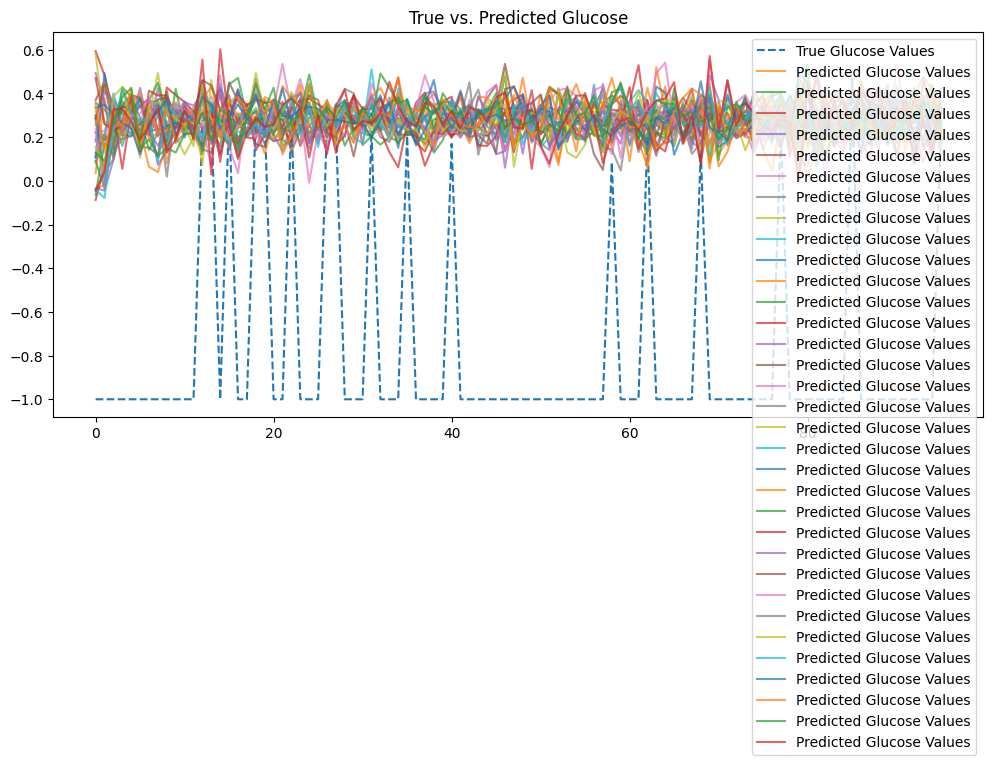

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Pick a random test window
idx = np.random.randint(len(labels))
true_values = labels[idx].cpu().numpy()
predicted_values = outputs[idx].detach().cpu().numpy()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(true_values, label="True Glucose Values", linestyle="dashed")
plt.plot(predicted_values, label="Predicted Glucose Values", alpha=0.7)
plt.legend()
plt.title("True vs. Predicted Glucose")
plt.show()